# Análisis y Preprocesado de Señales de Pulsioxímetro

Este notebook tiene como objetivo cargar, visualizar y preprocesar señales crudas (IR y RED) obtenidas de un sensor de pulsioxímetro. Se realiza lo siguiente:

1. **Carga de datos** desde múltiples archivos CSV ubicados en una carpeta específica.
2. **Selección de un registro concreto** para su análisis.
3. **Conversión de tiempo** de milisegundos a segundos y recorte a los primeros 30 segundos.
4. **Visualización gráfica** de las señales IR y RED originales.
5. **Eliminación de los primeros 5 segundos** de señal para evitar artefactos del arranque.
6. **Aplicación de un filtro digital pasa bajos** (Butterworth) para suavizar las señales.
7. **Preparación de las señales filtradas** para su posterior análisis (estimación de HR y SpO₂).


## Importar datos

- Esto guarda cada archivo CSV en un diccionario dataframes, donde la clave es el nombre del archivo y el valor es su DataFrame correspondiente.
- Puedes acceder a cualquier CSV con dataframes["nombre_del_archivo_sin_extension"].

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
folder_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos_limpios"

# Busca todos los archivos CSV en la carpeta
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Crear un diccionario con los DataFrames, usando el nombre del archivo sin extensión como clave
dataframes = {os.path.basename(file).replace('.csv', ''): pd.read_csv(file) for file in csv_files}

# Mostrar los nombres de los archivos cargados
print("Archivos cargados:", list(dataframes.keys()))

# Acceder a un DataFrame específico, por ejemplo:
nombre_archivo = "raw_data_95_77_2"  
df = dataframes[nombre_archivo]
df


Archivos cargados: ['raw_data_91_91', 'raw_data_92_76', 'raw_data_93_100', 'raw_data_95_77_2', 'raw_data_95_80', 'raw_data_95_81_papa', 'raw_data_95_99', 'raw_data_96_106', 'raw_data_96_69', 'raw_data_97_119', 'raw_data_97_95', 'raw_data_98_81', 'raw_data_98_86', 'raw_data_98_91', 'raw_data_99_75', 'raw_data_99_91']


,Tiempo (ms),IR,AMB_IR,RED,AMB_RED,IR_net,RED_net
0,3016,54062,1770,54621,1734,52292,52887
1,3031,54081,1774,54640,1734,52307,52906
2,3048,54110,1783,54681,1749,52327,52932
3,3065,54141,1796,54712,1757,52345,52955
4,3081,54173,1804,54751,1777,52369,52974
...,...,...,...,...,...,...,...
1616,29931,56828,2854,54827,2817,53974,52010
1617,29947,56846,2864,54832,2817,53982,52015
1618,29964,56873,2878,54880,2849,53995,52031
1619,29981,56884,2877,54905,2841,54007,52064


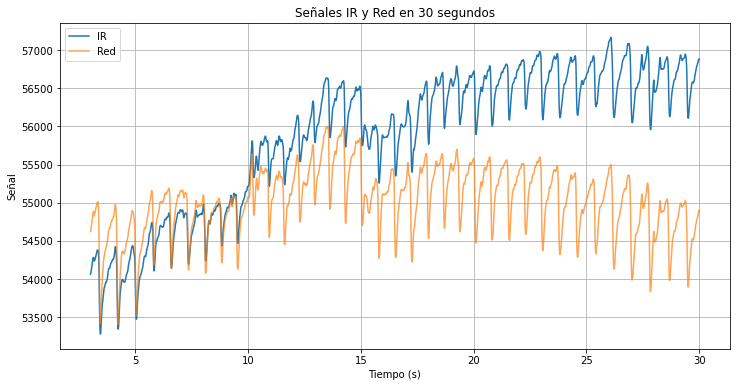

In [2]:
# Convertir el tiempo de milisegundos a segundos
df["Tiempo (ms)"] = df["Tiempo (ms)"] / 1000  # Ahora el tiempo está en segundos

# Filtrar hasta los 30 segundos
df_filtrado = df[df["Tiempo (ms)"] <= 30]

# Graficar con la escala correcta
plt.figure(figsize=(12, 6))
plt.plot(df_filtrado["Tiempo (ms)"], df_filtrado["IR"], label="IR")
plt.plot(df_filtrado["Tiempo (ms)"], df_filtrado["RED"], label="Red", alpha=0.7)
plt.xlabel("Tiempo (s)")
plt.ylabel("Señal")
plt.title("Señales IR y Red en 30 segundos")
plt.legend()
plt.grid()
plt.show()


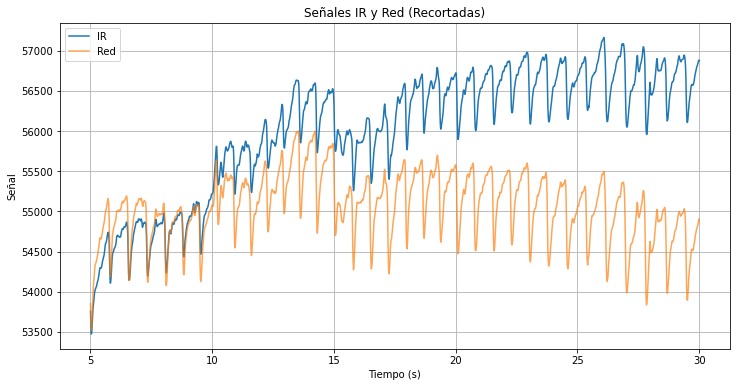

In [3]:
# Filtrar los primeros segundos para evitar valores extremos
df_recortado = df[df["Tiempo (ms)"] > 5]  # Ignoramos los primeros 5 segundos

# Graficar de nuevo con zoom
plt.figure(figsize=(12, 6))
plt.plot(df_recortado["Tiempo (ms)"], df_recortado["IR"], label="IR")
plt.plot(df_recortado["Tiempo (ms)"], df_recortado["RED"], label="Red", alpha=0.7)
plt.xlabel("Tiempo (s)")
plt.ylabel("Señal")
plt.title("Señales IR y Red (Recortadas)")
plt.legend()
plt.grid()
plt.show()

### Filtro paso-bajo Butterworth

In [4]:
from scipy.signal import butter, filtfilt

# Función para aplicar filtro pasa-bajos
def butter_lowpass_filter(data, cutoff=2.0, fs=60, order=3):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Aplicamos el filtro a las señales IR y RED
df_filtrado["IR_filtrado"] = butter_lowpass_filter(df_filtrado["IR"])
df_filtrado["RED_filtrado"] = butter_lowpass_filter(df_filtrado["RED"])


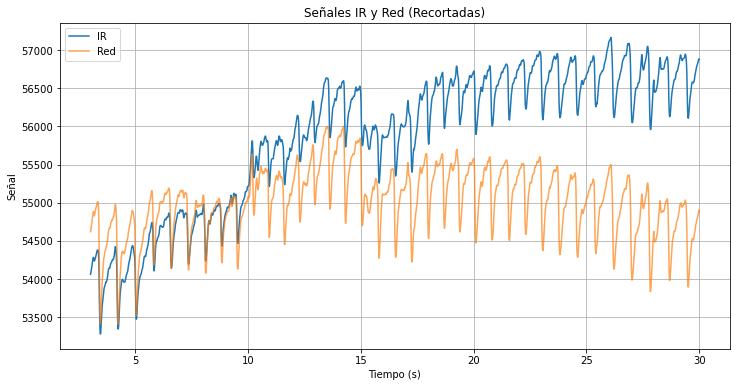

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df_filtrado["Tiempo (ms)"], df_filtrado["IR"], label="IR")
plt.plot(df_filtrado["Tiempo (ms)"], df_filtrado["RED"], label="Red", alpha=0.7)
plt.xlabel("Tiempo (s)")
plt.ylabel("Señal")
plt.title("Señales IR y Red (Recortadas)")
plt.legend()
plt.grid()
plt.show()

In [6]:
# Calcular la frecuencia de muestreo a partir de los datos
df_filtrado["Delta_t"] = df_filtrado["Tiempo (ms)"].diff()  # Diferencia de tiempos consecutivos
fs = 1000 / df_filtrado["Delta_t"].median()  # Convertimos de ms a Hz

print(f"Frecuencia de muestreo estimada: {fs:.2f} Hz")


Frecuencia de muestreo estimada: 58823.53 Hz


In [7]:
from scipy.signal import find_peaks

# Encontrar picos en la señal IR filtrada
peaks, _ = find_peaks(df_filtrado["IR_filtrado"], distance=fs//2)  # Espaciado mínimo entre picos (medio segundo)

# Calcular la frecuencia cardíaca en pulsaciones por minuto (BPM)
num_picos = len(peaks)
duracion_min = (df_filtrado["Tiempo (ms)"].iloc[-1] - df_filtrado["Tiempo (ms)"].iloc[0]) / 60
frecuencia_cardiaca = num_picos / duracion_min  

print(f"Frecuencia cardíaca estimada: {frecuencia_cardiaca:.2f} BPM")


Frecuencia cardíaca estimada: 2.22 BPM


In [8]:
# Cálculo de la Relación de Absorción (R)
r = (df_filtrado["RED_filtrado"].mean() / df_filtrado["IR_filtrado"].mean())

# Fórmula empírica para SpO2
spo2 = 110 - 25 * r  

print(f"Saturación de oxígeno estimada: {spo2:.2f}%")


Saturación de oxígeno estimada: 85.38%


In [9]:
print(df_filtrado[["Tiempo (ms)"]].head(10))  # Muestra los primeros 10 valores de tiempo
print(df_filtrado["Delta_t"].describe())  # Estadísticas de los intervalos de tiempo


   Tiempo (ms)
0        3.016
1        3.031
2        3.048
3        3.065
4        3.081
5        3.098
6        3.115
7        3.131
8        3.148
9        3.165
count    1620.000000
mean        0.016655
std         0.000508
min         0.015000
25%         0.016000
50%         0.017000
75%         0.017000
max         0.017000
Name: Delta_t, dtype: float64


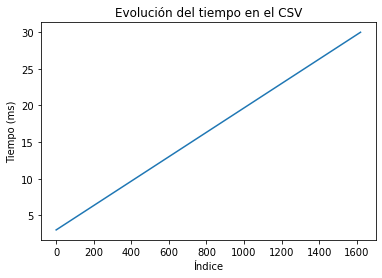

In [10]:
plt.plot(df_filtrado["Tiempo (ms)"])
plt.xlabel("Índice")
plt.ylabel("Tiempo (ms)")
plt.title("Evolución del tiempo en el CSV")
plt.show()


In [11]:
df_filtrado["Tiempo corregido"] = df_filtrado.index / 60  # Suponiendo 60 Hz


In [12]:
fs_estimada = df_filtrado["Delta_t"].mode()[0]  # Tomamos el valor más común
fs = 1000 / fs_estimada  # Convertimos de ms a Hz
print(f"Frecuencia de muestreo corregida: {fs:.2f} Hz")


Frecuencia de muestreo corregida: 58823.53 Hz
